In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import imblearn

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('tableau-colorblind10')
import seaborn as sns
from plotnine import *

In [2]:
data = pd.read_csv('BankChurners.csv')
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Loại bỏ 2 cột cuối cùng

In [3]:
data = data.drop(columns = ['CLIENTNUM', 
              'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
             'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

## Nhóm các giá trị vào các bin khác nhau và vẽ biểu đồ 

Nhóm theo độ tuổi - Customer Age
- Chia thành các nhóm tuổi: dưới 30, từ 30-40, 40-50, 50-60 và trên 60

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\2730409672.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


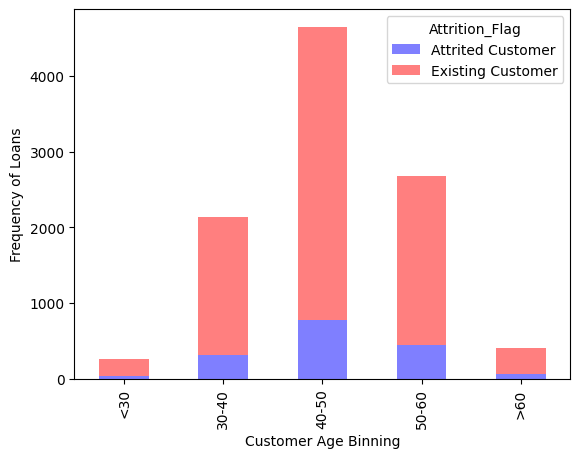

In [5]:
converter = lambda x: '<30' if (x <= 30) else \
                        ('30-40' if (x > 30 and x <= 40) else \
                        ('40-50' if (x > 40 and x <= 50) else \
                        ('50-60' if (x > 50 and x <= 60) else \
                        '>60')))


tmp = data['Customer_Age'].apply(converter)
data['Customer_Age_Binning'] = tmp

tmp2 = data.groupby('Customer_Age_Binning')['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2= tmp2.reset_index()
tmp2['Customer_Age_Binning'] = pd.Categorical(tmp2['Customer_Age_Binning'], 
                                              categories=['<30','30-40','40-50','50-60','>60'], 
                                              ordered=True)
import matplotlib.pyplot as plt
color_map = {'Existing Customer': 'blue', 'Attrited Customer': 'red'}
fig, ax = plt.subplots()
tmp2.groupby(['Customer_Age_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Customer Age Binning')
plt.ylabel('Frequency of Loans')
plt.show()

Đa số khách hàng là ở các độ tuổi là khách hàng đang dùng sản phẩm và ở độ tuổi từ 40-50

Nhóm theo Months on book (thời gian là khách hàng theo giá trị ghi sổ)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\2409208782.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\2409208782.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


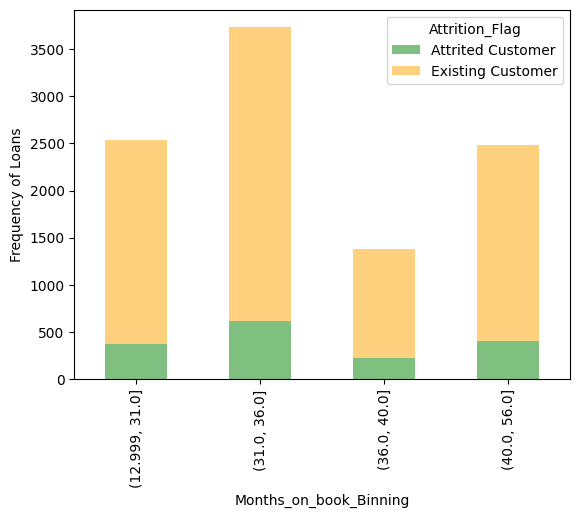

In [6]:
var = 'Months_on_book'
var_binning = var + '_Binning'
tmp = pd.qcut(data[var], q=4) #Chia thành 4 nhóm với thành 4 khoảng dựa trên quantities, số lượng quan sát gần bằng nhau
data[var_binning] = tmp

tmp2 = data.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()
color_map = {'Existing Customer': 'green', 'Attrited Customer': 'orange'}
fig, ax = plt.subplots()
tmp2.groupby(['Months_on_book_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Months_on_book_Binning')
plt.ylabel('Frequency of Loans')
plt.show()


Nhóm theo Credit Limit (Hạn mức tín dụng)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\1916187304.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\1916187304.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


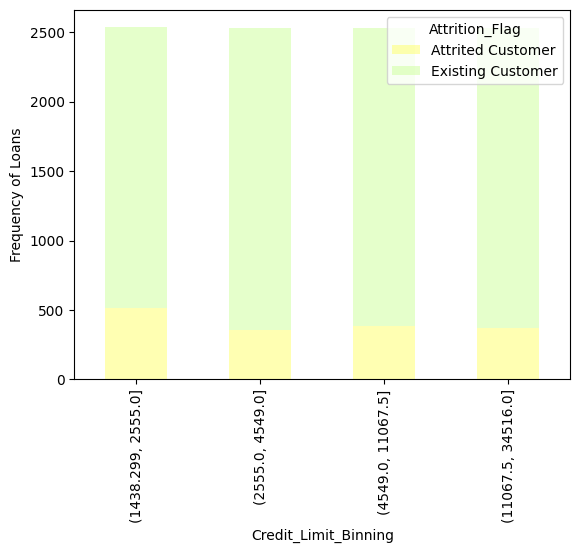

In [7]:
var = 'Credit_Limit'
var_binning = var + '_Binning'
tmp = pd.qcut(data[var], q=4) #Chia thành 4 nhóm với thành 4 khoảng dựa trên quantities, số lượng quan sát gần bằng nhau
data[var_binning] = tmp

tmp2 = data.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()
color_map = {'Existing Customer': '#FFFF66', 'Attrited Customer': '#CCFF99'}
fig, ax = plt.subplots()
tmp2.groupby(['Credit_Limit_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Credit_Limit_Binning')
plt.ylabel('Frequency of Loans')
plt.show()

Nhóm theo Total_Revolving_Bal (Tổng số dư quay vòng)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\2713632479.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\2713632479.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


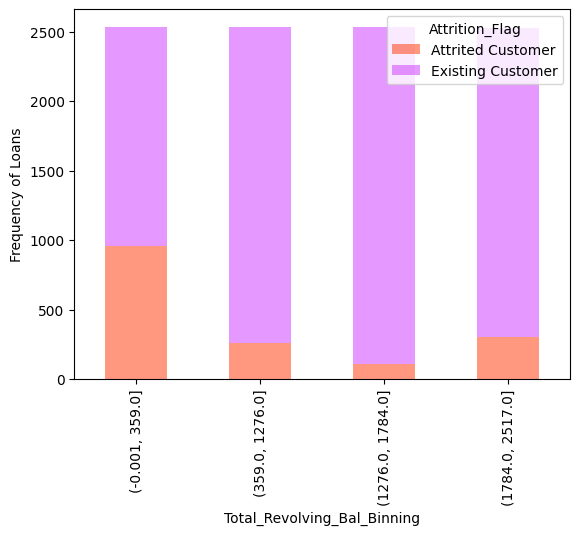

In [8]:
var = 'Total_Revolving_Bal'
var_binning = var + '_Binning'
tmp = pd.qcut(data[var], q=4) #Chia thành 4 nhóm với thành 4 khoảng dựa trên quantities, số lượng quan sát gần bằng nhau
data[var_binning] = tmp

tmp2 = data.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()
color_map = {'Existing Customer': '#FF3300', 'Attrited Customer': '#CC33FF'}
fig, ax = plt.subplots()
tmp2.groupby(['Total_Revolving_Bal_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Total_Revolving_Bal_Binning')
plt.ylabel('Frequency of Loans')
plt.show()

Nhóm theo Avg_Open_To_Buy 

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\3315271327.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\3315271327.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


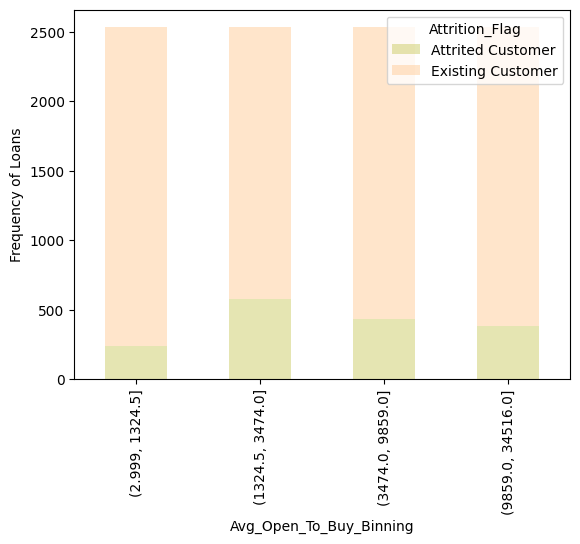

In [9]:
var = 'Avg_Open_To_Buy'
var_binning = var + '_Binning'
tmp = pd.qcut(data[var], q=4) #Chia thành 4 nhóm với thành 4 khoảng dựa trên quantities, số lượng quan sát gần bằng nhau
data[var_binning] = tmp

tmp2 = data.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()
color_map = {'Existing Customer': '#CCCC66', 'Attrited Customer': '#FFCC99'}
fig, ax = plt.subplots()
tmp2.groupby(['Avg_Open_To_Buy_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Avg_Open_To_Buy_Binning')
plt.ylabel('Frequency of Loans')
plt.show()

Nhóm theo Total_Amt_Chng_Q4_Q1 (Tổng thay đổi về số tiền giao dịch trong 4 quý vừa qua)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\2990608903.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\2990608903.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


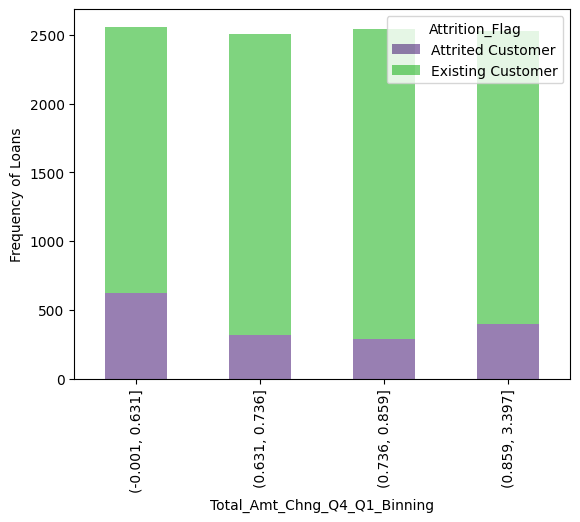

In [10]:
var = 'Total_Amt_Chng_Q4_Q1'
var_binning = var + '_Binning'
tmp = pd.qcut(data[var], q=4) #Chia thành 4 nhóm với thành 4 khoảng dựa trên quantities, số lượng quan sát gần bằng nhau
data[var_binning] = tmp

tmp2 = data.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()
color_map = {'Existing Customer': '#330066', 'Attrited Customer': '#00AA00'}
fig, ax = plt.subplots()
tmp2.groupby(['Total_Amt_Chng_Q4_Q1_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Total_Amt_Chng_Q4_Q1_Binning')
plt.ylabel('Frequency of Loans')
plt.show()

Nhóm theo Total_Trans_Amt (Tổng số tiền giao dịch trong 12 tháng vừa qua)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\1395512638.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\1395512638.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


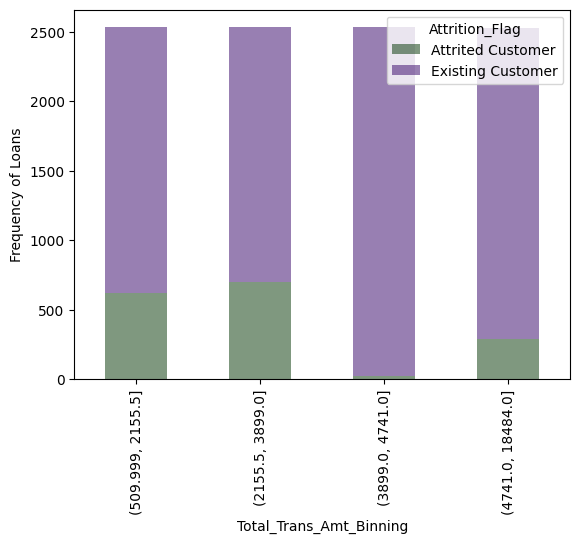

In [11]:
var = 'Total_Trans_Amt'
var_binning = var + '_Binning'
tmp = pd.qcut(data[var], q=4) #Chia thành 4 nhóm với thành 4 khoảng dựa trên quantities, số lượng quan sát gần bằng nhau
data[var_binning] = tmp

tmp2 = data.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()
color_map = {'Existing Customer': '#003300', 'Attrited Customer': '#330066'}
fig, ax = plt.subplots()
tmp2.groupby(['Total_Trans_Amt_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Total_Trans_Amt_Binning')
plt.ylabel('Frequency of Loans')
plt.show()

Nhóm theo Total_Trans_Ct (Tổng số giao dịch trong 12 tháng vừa qua)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\1325790718.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\1325790718.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


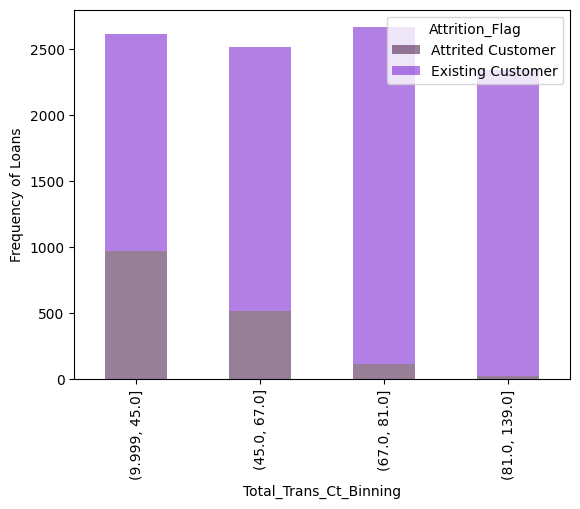

In [12]:
var = 'Total_Trans_Ct'
var_binning = var + '_Binning'
tmp = pd.qcut(data[var], q=4) #Chia thành 4 nhóm với thành 4 khoảng dựa trên quantities, số lượng quan sát gần bằng nhau
data[var_binning] = tmp

tmp2 = data.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()
color_map = {'Existing Customer': '#330033', 'Attrited Customer': '#6600CC'}
fig, ax = plt.subplots()
tmp2.groupby(['Total_Trans_Ct_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Total_Trans_Ct_Binning')
plt.ylabel('Frequency of Loans')
plt.show()

Nhóm theo Total_Ct_Chng_Q4_Q1 (Thay đổi về số lượng giao dịch trong 4 quý vừa qua)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\4197917468.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\4197917468.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


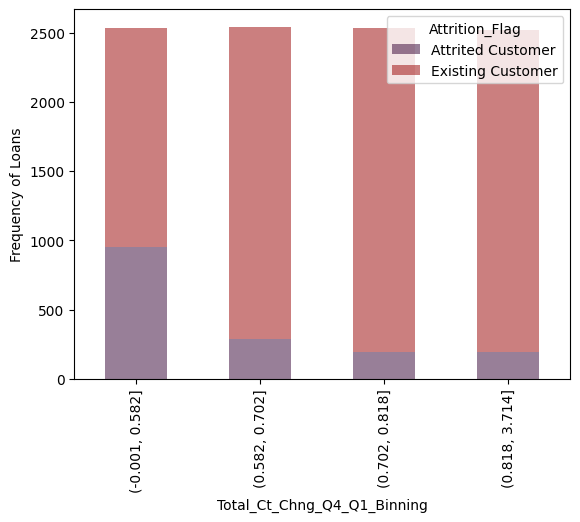

In [13]:
var = 'Total_Ct_Chng_Q4_Q1'
var_binning = var + '_Binning'
tmp = pd.qcut(data[var], q=4) #Chia thành 4 nhóm với thành 4 khoảng dựa trên quantities, số lượng quan sát gần bằng nhau
data[var_binning] = tmp

tmp2 = data.groupby(var_binning)['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2 = tmp2.reset_index()
color_map = {'Existing Customer': '#330033', 'Attrited Customer': '#990000'}
fig, ax = plt.subplots()
tmp2.groupby(['Total_Ct_Chng_Q4_Q1_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Total_Ct_Chng_Q4_Q1_Binning')
plt.ylabel('Frequency of Loans')
plt.show()

Nhóm theo Avg_Utilization_Ratio (Tỉ lệ sử dụng trung bình của thẻ tín dụng)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\180710488.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


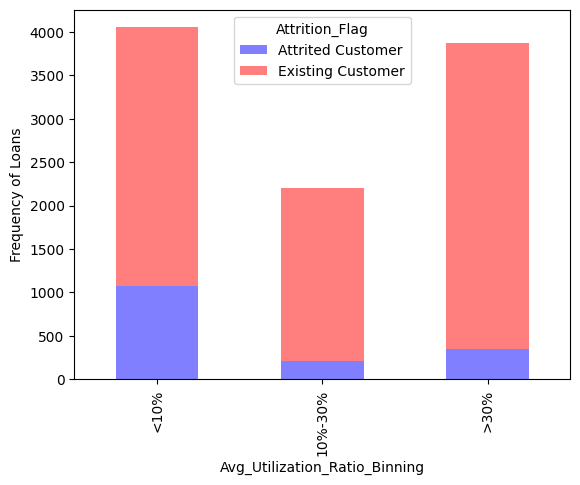

In [14]:
converter = lambda x: '<10%' if (x <= 0.1) else \
                        ('10%-30%' if (x > 0.1 and x <= 0.3) else \
                        ('>30%' ))


tmp = data['Avg_Utilization_Ratio'].apply(converter)
data['Avg_Utilization_Ratio_Binning'] = tmp

tmp2 = data.groupby('Avg_Utilization_Ratio_Binning')['Attrition_Flag'].value_counts()
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.rename(columns={'count':'Frequency_of_Loans'})
tmp2= tmp2.reset_index()
tmp2['Avg_Utilization_Ratio_Binning'] = pd.Categorical(tmp2['Avg_Utilization_Ratio_Binning'], 
                                              categories=['<10%','10%-30%','>30%'], 
                                              ordered=True)
import matplotlib.pyplot as plt
color_map = {'Existing Customer': 'blue', 'Attrited Customer': 'red'}
fig, ax = plt.subplots()
tmp2.groupby(['Avg_Utilization_Ratio_Binning', 'Attrition_Flag'])['Frequency_of_Loans'].sum().unstack().plot(kind='bar', 
            stacked=True, ax=ax, color=tmp2['Attrition_Flag'].map(color_map), alpha=0.5)

plt.xlabel('Avg_Utilization_Ratio_Binning')
plt.ylabel('Frequency of Loans')
plt.show()

# WOE (Weight of evidence) : Trọng số bằng chứng
## Định nghĩa
- WOE (weight of evidence) là một trong những kĩ thuật tạo đặc trưng (feature engineering) và lựa chọn đặc trưng (feature selection) khá hiệu quả.
- Phương pháp này sẽ xếp hạng các biến thành mạnh, trung bình, yếu, không tác động,… dựa trên điểm số đánh giá về sức mạnh dự báo nợ xấu. 

## Phương pháp WOE có 2 kỹ thuật xử lý
### Đối với biến liên tục
- Các bins sẽ là các khoảng liên tiếp được xác định từ biến liên tục sao cho số lượng quan sát ở mỗi bin là bằng nhau.
- Để xác định các bins thì ta cần xác định số lượng bins. 
- Các bins được ngăn cách bởi lượng tử hay quantile.

### Đối với biến phân loại
- WOE có thể chia mỗi một nhóm là một bin hoặc có thể nhóm vài nhóm có số lượng quan sát ít vào một bin. 
- Mức độ chênh lệch giữa phân phối GOOD/BAD được đo lường thông qua chỉ số WOE cũng có thể được sử dụng để nhận diện các nhóm có cùng tính chất phân loại. Nếu giá trị WOE của chúng càng gần nhau thì có thể chúng sẽ được nhóm vào một nhóm.
- Trường hợp Null cũng có thể được coi là một nhóm riêng biệt nếu số lượng của nó là đáng kể hoặc nhóm vào các nhóm khác nếu nó là thiểu số.

## Công thức WOE
- Trọng số bằng chứng được sử dụng để đo lường sự khác biệt giữa tỷ lệ %Good và %Bad trên từng bin. 
- Trọng số bằng chứng được tính toán bằng logarit của %Good/%Bad.
- Tính chất của WOE: Giá trị WOE tại một bin càng lớn là dấu hiệu chứng tỏ đặc trưng rất tốt trong việc nhận diện hồ sơ Good và trái lại nếu giá trị WOE càng nhỏ thì đặc trưng bin sẽ rất tốt trong việc nhận diện hồ sơ Bad.
- WOE > 1 thì phân phối của hồ sơ Good đang chiếm ưu thế hơn Bad và trái lại.

## IV (Information Value): trọng số thông tin
- Tiêu chuẩn xếp hạng các biến sẽ là chỉ số giá trị thông tin IV (information value) được tính toán từ phương pháp WOE. Đồng thời mô hình cũng tạo ra các đặc trưng cho mỗi biến. Giá trị này sẽ đo lường sự khác biệt trong phân phối giữa GOOD và BAD.
- Giá trị IV sẽ cho ta biết mức độ chênh lệch của %Good và %Bad ở mỗi bin là nhiều hay ít. 
- Nếu IV cao thì sự khác biệt trong phân phối giữa %Good và %Bad sẽ lớn và biến hữu ích hơn trong việc phân loại hồ sơ và trái lại IV nhỏ thì biến ít hữu ích trong việc phân loại hồ sơ.

### Tiêu chuẩn phân loại sức mạnh của biến theo IV
- Nhỏ hơn hoặc bằng 0.02: Biến không có tác dụng trong việc phân loại hồ sơ Good/Bad.
- 0.02 - 0.1: yếu
- 0.1 - 0.3: trung bình
- 0.3 - 0.5: mạnh
- Lớn hơn hoặc bằng 0.5: Biến rất mạnh, tuy nhiên trường hợp này cần được kiểm tra lại để tránh trường hợp biến có mối quan hệ trực tiếp để định nghĩa hồ sơ Good/Bad.

Kiểm tra lại dataset   

In [15]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Customer_Age_Binning,Months_on_book_Binning,Credit_Limit_Binning,Total_Revolving_Bal_Binning,Avg_Open_To_Buy_Binning,Total_Amt_Chng_Q4_Q1_Binning,Total_Trans_Amt_Binning,Total_Trans_Ct_Binning,Total_Ct_Chng_Q4_Q1_Binning,Avg_Utilization_Ratio_Binning
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,40-50,"(36.0, 40.0]","(11067.5, 34516.0]","(359.0, 1276.0]","(9859.0, 34516.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",<10%
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,40-50,"(40.0, 56.0]","(4549.0, 11067.5]","(359.0, 1276.0]","(3474.0, 9859.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",10%-30%
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,50-60,"(31.0, 36.0]","(2555.0, 4549.0]","(-0.001, 359.0]","(1324.5, 3474.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",<10%
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,30-40,"(31.0, 36.0]","(2555.0, 4549.0]","(1784.0, 2517.0]","(2.999, 1324.5]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",>30%
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,30-40,"(12.999, 31.0]","(4549.0, 11067.5]","(-0.001, 359.0]","(3474.0, 9859.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",<10%


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Attrition_Flag                 10127 non-null  object  
 1   Customer_Age                   10127 non-null  int64   
 2   Gender                         10127 non-null  object  
 3   Dependent_count                10127 non-null  int64   
 4   Education_Level                10127 non-null  object  
 5   Marital_Status                 10127 non-null  object  
 6   Income_Category                10127 non-null  object  
 7   Card_Category                  10127 non-null  object  
 8   Months_on_book                 10127 non-null  int64   
 9   Total_Relationship_Count       10127 non-null  int64   
 10  Months_Inactive_12_mon         10127 non-null  int64   
 11  Contacts_Count_12_mon          10127 non-null  int64   
 12  Credit_Limit                   1

Tính số lượng tình trạng khách hàng

In [17]:
data['Attrition_Flag'].value_counts()

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

Tính số lượng loại thẻ

In [18]:
data['Card_Category'].value_counts()

Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64

Tính số lượng tình trạng khách hàng đối với các tệp khách hàng có tỉ lệ tiêu dùng trung bình gần như bằng 0

In [19]:
data[data['Avg_Utilization_Ratio'] == 0]['Attrition_Flag'].value_counts()

Attrition_Flag
Existing Customer    1577
Attrited Customer     893
Name: count, dtype: int64

In [20]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Customer_Age_Binning,Months_on_book_Binning,Credit_Limit_Binning,Total_Revolving_Bal_Binning,Avg_Open_To_Buy_Binning,Total_Amt_Chng_Q4_Q1_Binning,Total_Trans_Amt_Binning,Total_Trans_Ct_Binning,Total_Ct_Chng_Q4_Q1_Binning,Avg_Utilization_Ratio_Binning
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,40-50,"(36.0, 40.0]","(11067.5, 34516.0]","(359.0, 1276.0]","(9859.0, 34516.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",<10%
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,40-50,"(40.0, 56.0]","(4549.0, 11067.5]","(359.0, 1276.0]","(3474.0, 9859.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",10%-30%
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,50-60,"(31.0, 36.0]","(2555.0, 4549.0]","(-0.001, 359.0]","(1324.5, 3474.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",<10%
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,30-40,"(31.0, 36.0]","(2555.0, 4549.0]","(1784.0, 2517.0]","(2.999, 1324.5]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",>30%
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,30-40,"(12.999, 31.0]","(4549.0, 11067.5]","(-0.001, 359.0]","(3474.0, 9859.0]","(0.859, 3.397]","(509.999, 2155.5]","(9.999, 45.0]","(0.818, 3.714]",<10%


In [21]:
selected_feature = ['Attrition_Flag', 
                   'Gender', 'Customer_Age_Binning', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 
                   'Months_on_book_Binning', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
                   'Credit_Limit_Binning', 'Total_Revolving_Bal_Binning', 'Avg_Open_To_Buy_Binning', 'Total_Amt_Chng_Q4_Q1_Binning', 
                   'Total_Trans_Amt_Binning', 'Total_Trans_Ct_Binning', 'Total_Ct_Chng_Q4_Q1_Binning', 'Avg_Utilization_Ratio_Binning']

data = data[selected_feature]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Attrition_Flag                 10127 non-null  object  
 1   Gender                         10127 non-null  object  
 2   Customer_Age_Binning           10127 non-null  object  
 3   Dependent_count                10127 non-null  int64   
 4   Education_Level                10127 non-null  object  
 5   Marital_Status                 10127 non-null  object  
 6   Income_Category                10127 non-null  object  
 7   Months_on_book_Binning         10127 non-null  category
 8   Total_Relationship_Count       10127 non-null  int64   
 9   Months_Inactive_12_mon         10127 non-null  int64   
 10  Contacts_Count_12_mon          10127 non-null  int64   
 11  Credit_Limit_Binning           10127 non-null  category
 12  Total_Revolving_Bal_Binning    1

Tính chỉ số WOE và IV

In [22]:
iv_list = []

for var in selected_feature[1:]:
    new_var = var + '_woe'
    #Tạo bảng chỉ số WOE
    tmp = data.groupby(var)['Attrition_Flag'].value_counts()
    tmp = pd.DataFrame(tmp)
    tmp = tmp.rename(columns={'count':'Frequency_of_Loans'})
    tmp = tmp.reset_index()
    woe_table = tmp.pivot(index=var, columns='Attrition_Flag', values='Frequency_of_Loans')

    
    # Tính chỉ số WOE và IV
    num_attrited = woe_table['Attrited Customer'].sum()
    num_existing = woe_table['Existing Customer'].sum()

    woe_table['DB'] = woe_table['Attrited Customer']/num_attrited
    woe_table['DG'] = woe_table['Existing Customer']/num_existing
    woe_table['perc_diff'] = woe_table['DG']-woe_table['DB']
    woe_table['woe'] = np.log(woe_table['DG']/woe_table['DB'])

    # Lưu lại chỉ số IV vào iv_list
    iv_data = {'var':var, 
               'iv':(woe_table['perc_diff']*woe_table['woe']).sum()}
    iv_list.append(iv_data)

    # đưa các giá trị WOE tính được vào các cột biến woe mới
    data[new_var] = pd.merge(data, woe_table, how='left', left_on=var, 
                                right_index=True)['woe']

C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\3620068366.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\3620068366.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\3620068366.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Admin\AppData\Local\Temp\ipykernel_21580\3620068366.py:7: FutureWarning: The defau

In [23]:
data.head()

,Attrition_Flag,Gender,Customer_Age_Binning,Dependent_count,Education_Level,Marital_Status,Income_Category,Months_on_book_Binning,Total_Relationship_Count,Months_Inactive_12_mon,...,Months_Inactive_12_mon_woe,Contacts_Count_12_mon_woe,Credit_Limit_Binning_woe,Total_Revolving_Bal_Binning_woe,Avg_Open_To_Buy_Binning_woe,Total_Amt_Chng_Q4_Q1_Binning_woe,Total_Trans_Amt_Binning_woe,Total_Trans_Ct_Binning_woe,Total_Ct_Chng_Q4_Q1_Binning_woe,Avg_Utilization_Ratio_Binning_woe
0,Existing Customer,M,40-50,3,High School,Married,$60K - $80K,"(36.0, 40.0]",5,1,...,1.406786,-0.276254,0.115126,0.510127,0.065255,0.019708,-0.522866,-1.124281,0.840652,-0.626787
1,Existing Customer,F,40-50,5,Graduate,Single,Less than $40K,"(40.0, 56.0]",6,1,...,1.406786,0.293645,0.057742,0.510127,-0.066945,0.019708,-0.522866,-1.124281,0.840652,0.600730
2,Existing Customer,M,50-60,3,Graduate,Married,$80K - $120K,"(31.0, 36.0]",4,1,...,1.406786,2.372023,0.163078,-1.151760,-0.430779,0.019708,-0.522866,-1.124281,0.840652,-0.626787
3,Existing Customer,F,30-40,4,High School,Unknown,Less than $40K,"(31.0, 36.0]",3,4,...,-0.800551,0.902319,0.163078,0.347972,0.621764,0.019708,-0.522866,-1.124281,0.840652,0.659235
4,Existing Customer,M,30-40,3,Uneducated,Married,$60K - $80K,"(12.999, 31.0]",5,1,...,1.406786,2.372023,0.057742,-1.151760,-0.066945,0.019708,-0.522866,-1.124281,0.840652,-0.626787


Sau khi tính được chỉ số WOE, biểu diễn trực quan hóa chỉ số IV để xem xét mức độ ảnh hưởng của các biến

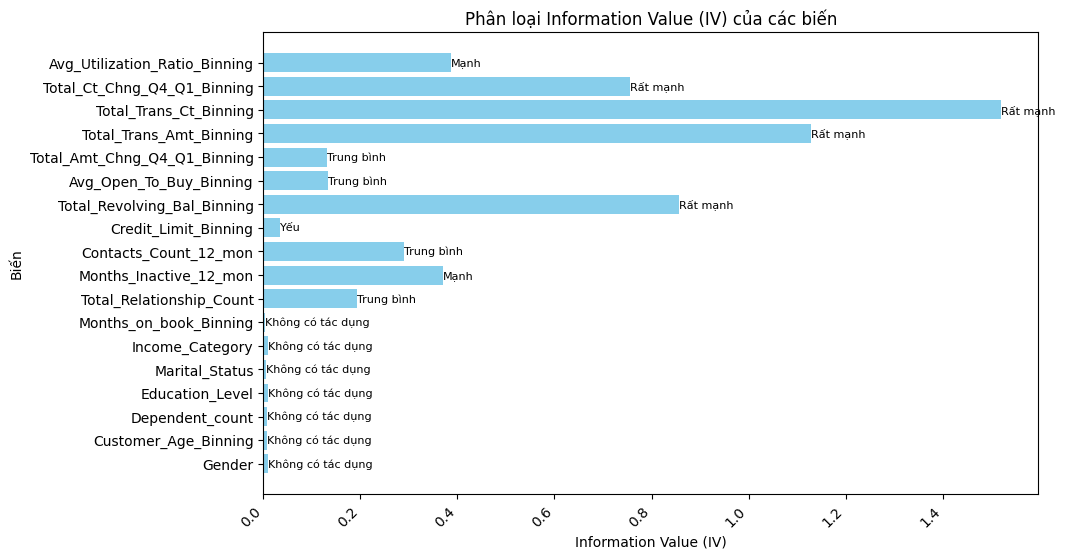

In [26]:
# Tạo danh sách tên biến và giá trị IV
variables = [iv_data['var'] for iv_data in iv_list]
iv_values = [iv_data['iv'] for iv_data in iv_list]

# Phân loại biến dựa trên giá trị IV
t = []
for iv in iv_values:
    if iv <= 0.02:
        t.append('Không có tác dụng')
    elif 0.02 < iv <= 0.1:
        t.append('Yếu')
    elif 0.1 < iv <= 0.3:
        t.append('Trung bình')
    elif 0.3 < iv <= 0.5:
        t.append('Mạnh')
    else:
        t.append('Rất mạnh')

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.barh(variables, iv_values, color='skyblue')
plt.xlabel('Information Value (IV)')
plt.ylabel('Biến')
plt.title('Phân loại Information Value (IV) của các biến')
plt.xticks(rotation=45, ha='right')

# Hiển thị chú thích về phân loại
for i, txt in enumerate(classification):
    plt.annotate(txt, (iv_values[i], i), fontsize=8, ha='left', va='center')

plt.show()


- Các biến có chỉ số IV rất mạnh (có ý nghĩa thống kê cao) gồm Total_Ct_Chng_Q4_Q1_Binning, Total_Trán_Ct_Binning, Total_Trans_Amt_Binning và Total_Revolving_Bal_Binning
- Các biến không có ý nghĩa đối với mô hình gồm Months_on_book_Binning, Income_Category, Marital_Status, Education_Level, Dependent_count, Customer_Age_Binning và Gender.